In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib as mpl
# use precise epoch
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

# data_dir = '/home/mnedal/data'
data_dir = '/home/mnedal/data/nenufar_data' # on the DIAS-lofar machine
mydate = '2025-03-25'

In [2]:
year, month, day = mydate.split('-')

In [3]:
# files = glob.glob(f'{data_dir}/NDA_{day}{month}{year}_*.fits')

files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')

orfees_data = pyfits.open(files[0])
orfees_data.info()

Filename: /home/mnedal/data/nenufar_data/int_orf20250325_053100_0.1.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  FREQUENCIES    1 BinTableHDU     37   1R x 11C   [1J, 1J, 431E, 1J, 215E, 1J, 164E, 1J, 86E, 1J, 102E]   
  2  SPECTRA       1 BinTableHDU     78   358292R x 15C   [1J, 431E, 431E, 1J, 215E, 215E, 1J, 164E, 164E, 1J, 86E, 86E, 1J, 102E, 102E]   


In [43]:
orfees_data[2].header['BUNIT']

'SFU/PIXEL'

In [4]:
# define x and y axes
orfees_freq = pd.DataFrame(orfees_data[3].data).values.reshape(-1)
orfees_time = pd.DataFrame(orfees_data[4].data).values.reshape(-1)

orfees_arr1 = orfees_data[1].data
orfees_arr2 = orfees_data[2].data

orfees_arr1 = 10 * np.log10(orfees_arr1) # Convert the amplitude to decibels
orfees_arr2 = 10 * np.log10(orfees_arr2) # Convert the amplitude to decibels

datetime_obj_start = orfees_data[0].header['DATE-OBS'] + ' ' + orfees_data[0].header['TIME-OBS']
datetime_obj_end   = orfees_data[0].header['DATE-OBS'] + ' ' + orfees_data[0].header['TIME-END']

start_obs_time = datetime.strptime(datetime_obj_start, '%d/%m/%Y %H:%M:%S')
end_obs_time   = datetime.strptime(datetime_obj_end, '%d/%m/%Y %H:%M:%S')

time_in_seconds = orfees_data[4].data['time_in_seconds']
times = [start_obs_time + timedelta(seconds=ts) for ts in time_in_seconds]

In [5]:
if len(times) < orfees_arr1.shape[1]:
    # num of missed time steps
    n_miss = [orfees_arr1.shape[1] - len(times)]
    dt = np.diff(time_in_seconds)[-1] # time cadence
    for n in n_miss:
        times.append(times[-1] + timedelta(seconds=dt))

assert len(times) == orfees_arr1.shape[1], 'Length of time axis does not match the data array x-dim'

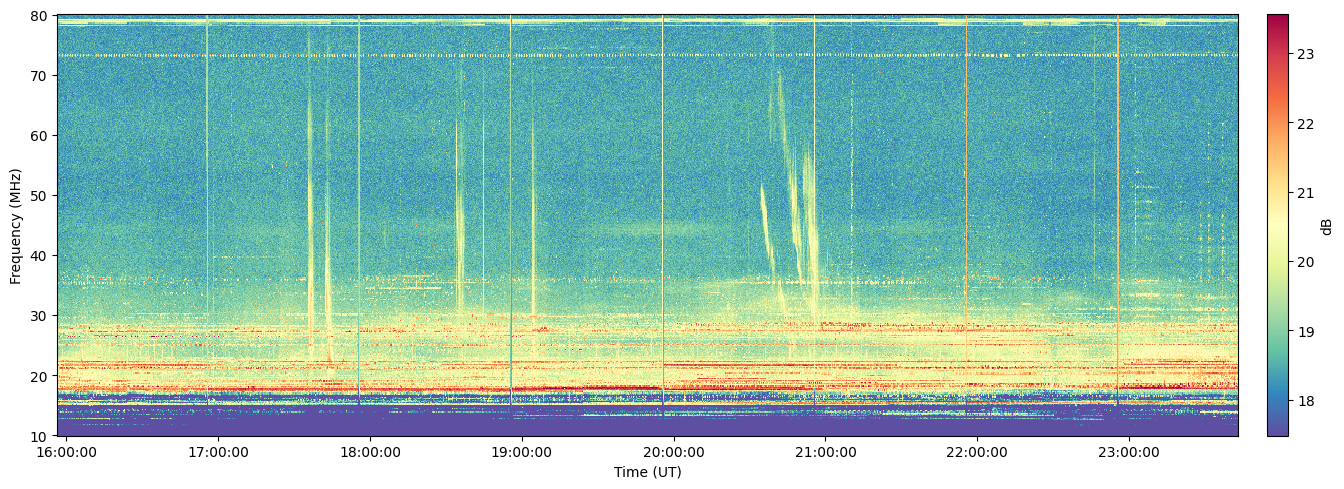

In [6]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(times, orfees_freq, orfees_arr1,
                   vmin=np.nanpercentile(orfees_arr1, 7),
                   vmax=np.nanpercentile(orfees_arr1, 99.97),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

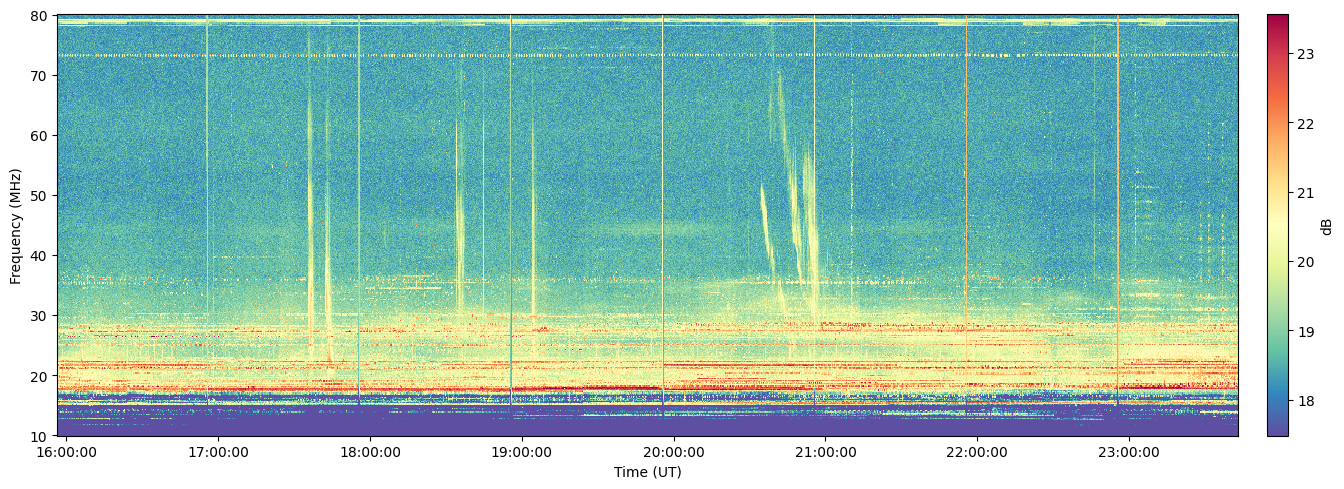

In [8]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(times, orfees_freq, orfees_arr2,
                   vmin=np.nanpercentile(orfees_arr2, 7),
                   vmax=np.nanpercentile(orfees_arr2, 99.97),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

### From Shilpi
#### originally prepared by Shane Maloney and Pearse Murphy

In [4]:
#### Plot ORFEES spectra
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import time, os, pdb
import time, os
from matplotlib import dates
import matplotlib.ticker as ticker
import argparse
from datetime import datetime
from matplotlib import dates
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
from astropy.io import fits
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from matplotlib.colors import LogNorm
from radiospectra.spectrogram2 import Spectrogram

In [5]:
orfees = fits.open(files[0])
print(*orfees, sep='\n')

In [6]:
orfees.info()

Filename: /home/mnedal/data/nenufar_data/int_orf20250325_053100_0.1.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  FREQUENCIES    1 BinTableHDU     37   1R x 11C   [1J, 1J, 431E, 1J, 215E, 1J, 164E, 1J, 86E, 1J, 102E]   
  2  SPECTRA       1 BinTableHDU     78   358292R x 15C   [1J, 431E, 431E, 1J, 215E, 215E, 1J, 164E, 164E, 1J, 86E, 86E, 1J, 102E, 102E]   


In [47]:
orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
orfees_i.shape

(998, 358292)

In [48]:
data = orfees_i.T
data.shape

(358292, 998)

1. What is the purpose of this loop?
```python
for i in range(data.shape[0]):
	data[i] = data[i]/data[-1]
```

2. What is the unit of the time values in this array? ms?
```python
orfees[2].data['TIME_B1']
```

3. Why the times are not prepared like this?
```python
np.hstack([Time(orfees_time_str) + (orfees[2].data[f'TIME_B{i}']/1000)*u.s for i in range(1, 6)])
```

In [49]:
orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz

In [50]:
# Remove the background by taking the data from the quiet background and divide it by the data
for i in range(data.shape[0]):
	data[i] = data[i]/data[35000]

In [51]:
orfees_times.shape, orfees_freqs.reshape(-1).shape, data.shape

((358292,), (998,), (358292, 998))

In [52]:
df = pd.DataFrame(data=data, index=orfees_times, columns=orfees_freqs.value.reshape(-1))
df.index.name   = 'Time'
df.columns.name = 'Frequency'
df.head()

Frequency                144.130005   144.520004   144.910004   145.300003   \
Time                                                                          
2025-03-25 06:56:06.740     0.928571     0.942857     0.930643     0.932936   
2025-03-25 06:56:06.840     0.964286     0.971429     0.889129     0.914873   
2025-03-25 06:56:06.940     1.142857     1.057143     0.910613     0.932936   
2025-03-25 06:56:07.040     0.892857     0.942857     0.910613     0.932936   
2025-03-25 06:56:07.140     0.928571     0.914286     0.910613     0.932936   

Frequency                145.690002   146.960007   148.089996   148.429993   \
Time                                                                          
2025-03-25 06:56:06.740     0.923690     0.942021     0.922414     0.935483   
2025-03-25 06:56:06.840     0.912377     0.956650     0.931035     0.929009   
2025-03-25 06:56:06.940     0.926278     0.971011     0.931035     0.935483   
2025-03-25 06:56:07.040     0.887289     0.971011     0.913793     0.941956   
2025-03-25 06:56:07.140     0.887289     0.956382     0.913793     0.941956   

Frequency                148.820007   149.210007   ...  990.729980   \
Time                                               ...                
2025-03-25 06:56:06.740     0.942299     0.948429  ...          1.0   
2025-03-25 06:56:06.840     0.910239     0.935460  ...          1.0   
2025-03-25 06:56:06.940     0.923037     0.954826  ...          1.0   
2025-03-25 06:56:07.040     0.929415     0.974236  ...          1.0   
2025-03-25 06:56:07.140     0.923037     0.948385  ...          1.0   

Frequency                992.289978   993.859985   995.419983   996.979980   \
Time                                                                          
2025-03-25 06:56:06.740     0.958380          1.0     0.947432     0.965080   
2025-03-25 06:56:06.840     0.979342          1.0     0.947432     0.988375   
2025-03-25 06:56:06.940     0.989678          1.0     0.895399     0.953605   
2025-03-25 06:56:07.040     0.979183          1.0     0.968459     0.976705   
2025-03-25 06:56:07.140     0.979140          1.0     0.947566     0.976840   

Frequency                998.539978   1000.109985  1001.669983  1003.229980  \
Time                                                                          
2025-03-25 06:56:06.740          1.0     0.933695     0.999757     1.000000   
2025-03-25 06:56:06.840          1.0     0.959333     0.999757     1.000000   
2025-03-25 06:56:06.940          1.0     0.959712     1.017636     1.000000   
2025-03-25 06:56:07.040          1.0     0.907552     0.982486     1.017971   
2025-03-25 06:56:07.140          1.0     0.959333     1.017514     1.000000   

Frequency                1004.700012  
Time                                  
2025-03-25 06:56:06.740          1.0  
2025-03-25 06:56:06.840          1.0  
2025-03-25 06:56:06.940          1.0  
2025-03-25 06:56:07.040          1.0  
2025-03-25 06:56:07.140          1.0  

[5 rows x 998 columns]

In [53]:
df.index = [t.datetime for t in df.index]

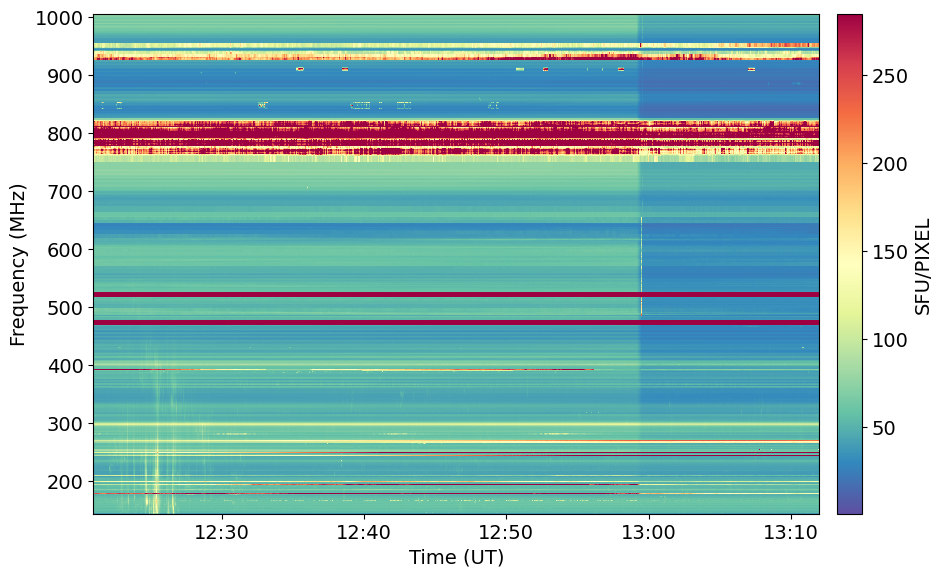

In [56]:
start_time = '2025-03-25T12:21:00'
end_time   = '2025-03-25T13:12:00'

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   vmin=np.nanpercentile(df_orfees_1s, 1),
                   vmax=np.nanpercentile(df_orfees_1s, 96),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees_data[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp(start_time), right=pd.Timestamp(end_time))
fig.tight_layout()
plt.show()

In [55]:
df_orfees_1s = df.resample('1S').mean()

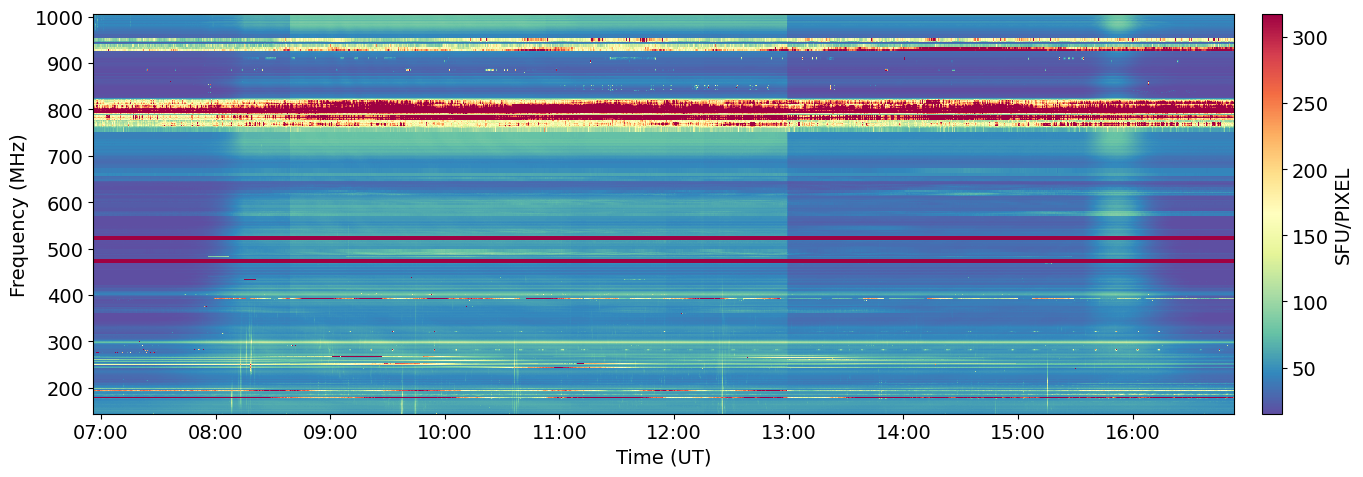

In [45]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   vmin=np.nanpercentile(df_orfees_1s, 1),
                   vmax=np.nanpercentile(df_orfees_1s, 96),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees_data[2].header['BUNIT'])
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [31]:
# Remove constant background
df_new = df_orfees_1s - np.tile(np.mean(df_orfees_1s,0), (df_orfees_1s.shape[0],1))

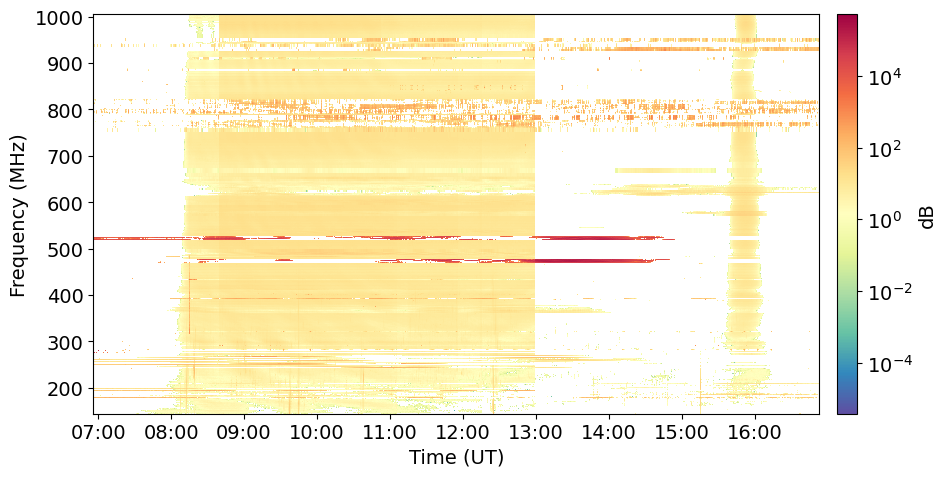

In [36]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_new.index, df_new.columns, df_new.T,
                   # vmin=np.nanpercentile(df_new, 1),
                   # vmax=np.nanpercentile(df_new, 96),
                   # norm=LogNorm(vmin=np.nanpercentile(df_new, 1), vmax=np.nanpercentile(df_new, 96)),
                   # norm=LogNorm(),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

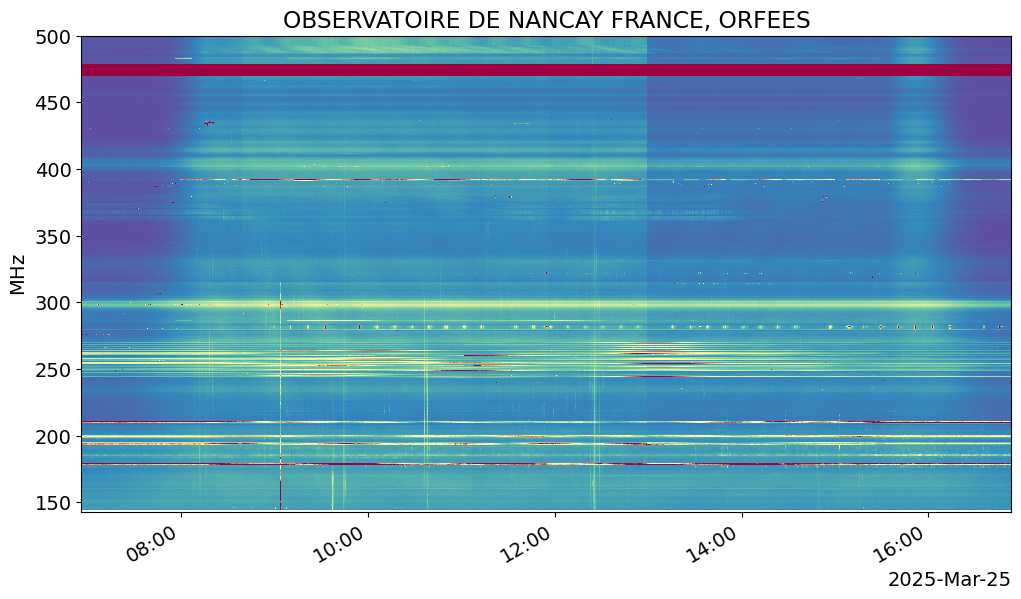

In [6]:
import matplotlib.ticker as ticker
import argparse
from datetime import datetime
from matplotlib import dates
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
from astropy.io import fits
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from matplotlib.colors import LogNorm
from radiospectra.spectrogram2 import Spectrogram

# orfees = fits.open('/Users/shilpibhunia/Documents/event_2025_03_25/data/int_orf20250325_122000_0.1.fts')
orfees = fits.open(files[0])

orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
data = orfees_i.T

# Remove the background by taking the data from the quiet background and divide it by the data
#for i in range(data.shape[0]):
#	data[i] = data[i]/data[35000]

data = data.T
#pdb.set_trace()

orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)]) *u.MHz

orfees_meta = {
    'observatory': orfees[0].header['ORIGIN'],
    'instrument': orfees[0].header['INSTRUME'],
    'detector': orfees[0].header['INSTRUME'],
    'freqs': orfees_freqs.reshape(-1),
    'times': orfees_times,
    'wavelength': a.Wavelength(orfees_freqs[0,0], orfees_freqs[0,-1]),
    'start_time': orfees_times[0],
    'end_time': orfees_times[-1]
}

###### Plot the spec
orfees_spec_i = Spectrogram(data, orfees_meta)
#pdb.set_trace()
vmm = np.percentile(orfees_spec_i.data, [1,96])
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
#orfees_spec_i.plot(axes = ax, norm=LogNorm(vmin=vmm[0], vmax=vmm[1]), cmap = 'Spectral_r')
orfees_spec_i.plot(axes = ax, vmin=vmm[0], vmax=vmm[1], cmap = 'Spectral_r')
ax.set_ylim(143,500)
plt.show()

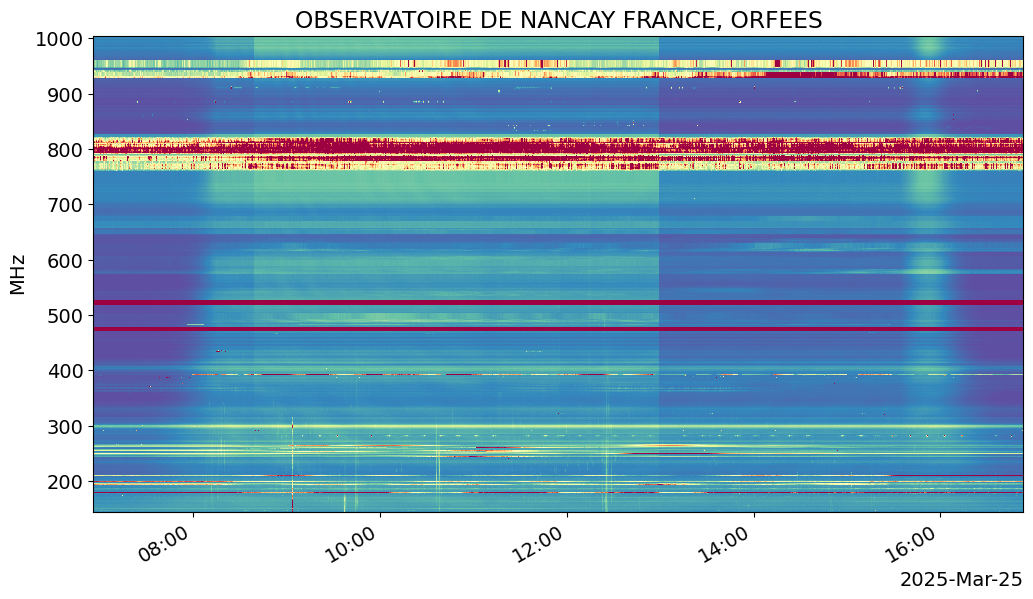

In [7]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
orfees_spec_i.plot(axes = ax, vmin=vmm[0], vmax=vmm[1], cmap = 'Spectral_r')
plt.show()